In [1]:
import numpy as np
import pandas as pd

In [2]:
def strings_to_floats(data):
    df = pd.DataFrame(data)
    df.lat = df.lat.astype(float)
    df.lon = df.lon.astype(float)
    df.alt = df.alt.astype(float)
    return df

def read_file(fname):
    with open(fname) as f:
        contents = f.readlines()
    seed = contents[0].strip()
    print(seed)
    satellites = parse_satellites(contents)
    start_end = parse_startend(contents)
    df = satellites.append(start_end).reset_index()
    return strings_to_floats(df)

def parse_startend(data):
    line = list(map(lambda x: x.strip().split(','), filter(lambda x: 'ROUTE' in x, data)))[0]
    start = ['START'] + line[1:3] + [0]
    end = ['END'] + line[3:] + [0]
    return pd.DataFrame([start, end], columns=['ID', 'lat', 'lon', 'alt'])

def parse_satellites(data):
    lines = map(lambda x: x.strip().split(','), filter(lambda x: 'SAT' in x, data))
    return pd.DataFrame(list(lines), columns=['ID', 'lat', 'lon', 'alt'])
    

In [3]:
def find_shortest_path(graph, start, end, path=[]):
        path = path + [start]
        if start == end:
            return path
        if not start in graph:
            return None
        shortest = None
        for node in graph[start]:
            if node not in path:
                newpath = find_shortest_path(graph, node, end, path)
                if newpath:
                    if not shortest or len(newpath) < len(shortest):
                        shortest = newpath
        return shortest

In [4]:
def lat_to_rads(lat):
    return (90 - lat)*np.pi/180
    
def lon_to_rads(lon):
    return (lon+180)*np.pi/180

def spherical_to_cartesian(df):
    r = 6371 + df.alt.values
    theta = lat_to_rads(df.lat.values)
    phi = lon_to_rads(df.lon.values)
    coords = np.dstack((df.ID.values,
                              r * np.sin(theta) * np.cos(phi),
                              r * np.sin(theta) * np.sin(phi),
                              r * np.cos(theta)))
    return coords[0]

def line_distance_to_origo(x1, x2):
    return np.linalg.norm(np.cross(-x1, -x2))/np.linalg.norm(x2- x1)

def distance_to_origo(x1, x2):
    return np.linalg.norm(np.cross(-x1, -x2))/np.linalg.norm(x2- x1)

def distance_between_points(x1, x2):
    return np.linalg.norm(x1-x2)

def point_between_points(x0, x1, x2):
    return np.abs(distance_between_points(x0, x1) + distance_between_points(x0, x2)
                  - distance_between_points(x1, x2)) < 1

def closest_intersection_to_line(x1, x2):
    t = -np.dot(x1, x2 - x1)/np.power(np.linalg.norm(x2 - x1),2)
    return np.array([x1[0] + (x2[0] - x1[0])*t,
                     x1[1] + (x2[1] - x1[1])*t,
                     x1[2] + (x2[2] - x1[2])*t])

def get_connecting_nodes(node, data):
    intersects = np.apply_along_axis(lambda x: closest_intersection_to_line(x[1:].astype(float), node[1:].astype(float)),
                                     axis=1, arr=data)
    data_and_intersects = np.column_stack((data, intersects))
    mask = np.apply_along_axis(lambda x: point_between_points(x[4:].astype(float), node[1:].astype(float),
                                                              x[1:4].astype(float)),
                               axis=1,
                               arr=data_and_intersects)
    data2 = np.column_stack((data, mask, 10000*np.ones((data.shape[0], 1))))
    data2[:,5][data2[:,4] == True] = np.apply_along_axis(lambda x: distance_to_origo(node[1:].astype(float),
                                                                               x[1:4].astype(float)),
                                                   axis=1, arr=data2[data2[:,4] == True])
    data2[:,5][data2[:,0] == node[0]] = 0
    return data2[data2[:,5].astype(float)>6371][:,0]

In [5]:
spherical = read_file('generate.txt')
coords = spherical_to_cartesian(spherical)

#SEED: 0.1556158389430493


In [6]:
graph = {row[0]: list(get_connecting_nodes(row, coords)) for row in coords}

In [7]:
path = find_shortest_path(graph, 'START', 'END')
','.join(path)

'START,SAT12,SAT8,SAT3,SAT10,SAT5,END'

In [8]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import pylab
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 20

/usr/local/lib/python3.4/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.4/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


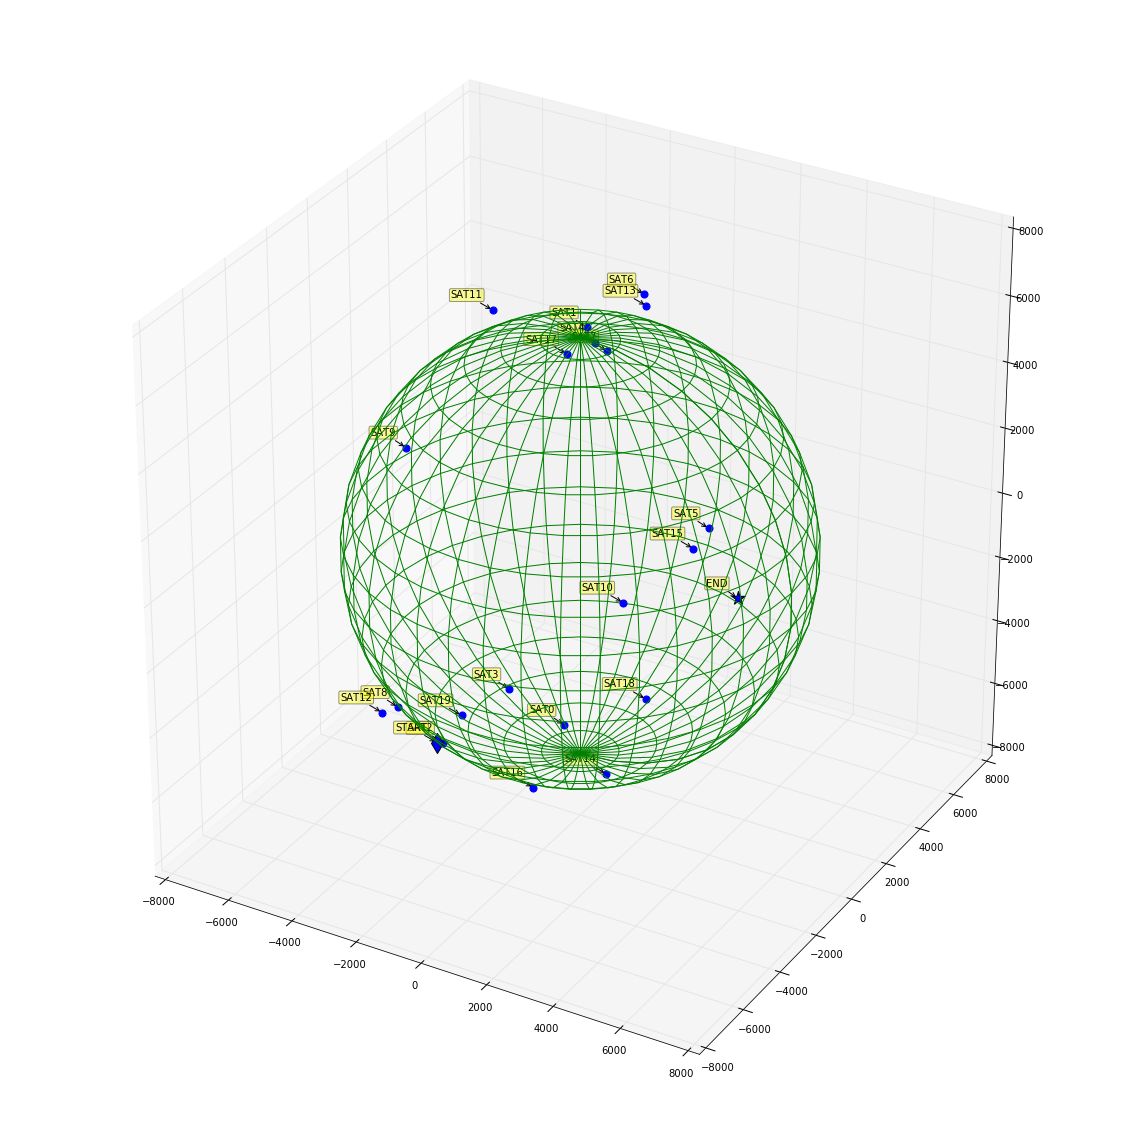

In [9]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_aspect("equal")
#draw sphere
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
r=6371
x=6371*np.cos(u)*np.sin(v)
y=6371*np.sin(u)*np.sin(v)
z=6371*np.cos(v)
ax.plot_wireframe(x, y, z, color="g")
for row in coords:
    if 'SAT' in row[0]:
        ax.scatter(row[1], row[2], row[3], color="b", s=50)
    elif 'END' in row[0]:
        ax.scatter(row[1], row[2], row[3], color="k", s=200, marker='*')
    else:
        ax.scatter(row[1], row[2], row[3], color="k", s=200, marker='d')
    x, y, _ = proj3d.proj_transform(row[1], row[2], row[3], ax.get_proj())
       
    label = pylab.annotate(
        row[0], xy = (x, y), xytext = (-10, 10),
    textcoords = 'offset points', ha = 'right', va = 'bottom',
    bbox = dict(boxstyle = 'round,pad=0.14', fc = 'yellow', alpha = 0.4),
    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))